In [34]:
# Блок 1 - импорт
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

# SMOTE для балансировки классов
from imblearn.over_sampling import SMOTE

In [35]:
# Блок 2 - загрузка данных
data = pd.read_excel('class.xlsx')
df = pd.DataFrame(data)

print(df)
print("Колонки:", df.columns.tolist())

    Yн  Zн  Yс  Zс  Yв  Zв      U      Т
0   35   2  27   1  29   1  10.54  79.01
1   28   1  26   1  28   1  10.83  66.18
2   30   1  26   1  26   1  10.63  77.86
3   26   1  25   1  25   1  10.72  73.63
4   32   1  27   1  27   1  10.73  68.97
..  ..  ..  ..  ..  ..  ..    ...    ...
95  16   3  24   1  27   1  10.99  70.14
96  23   1  26   1  17   3  10.50  67.98
97  28   1  30   1  41   3  10.47  77.19
98  30   1  33   2  42   3  10.32  68.56
99  24   1  26   1  16   3  10.69  63.23

[100 rows x 8 columns]
Колонки: ['Yн', 'Zн', 'Yс', 'Zс', 'Yв', 'Zв', 'U', 'Т']


In [36]:
# Блок 3 - формирование признаков и целевой переменной
X = df[['Yв', 'U', 'Т']]
y = df['Zв']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.25,
    random_state=44
)

print(f"Всего классов: {len(y.unique())}")
print("Распределение классов:\n", y.value_counts().sort_index())

Всего классов: 3
Распределение классов:
 Zв
1    69
2    26
3     5
Name: count, dtype: int64


In [37]:
# Блок 4 - нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def balance_classes(X, y):
    # Рассчитываем веса классов
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Используем SMOTE для балансировки
    smote = SMOTE(k_neighbors=1, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled, class_weight_dict

# Применение
print("До балансировки:", np.bincount(y_train))
X_train_balanced, y_train_balanced, class_weights = balance_classes(X_train_scaled, y_train)
print("После балансировки:", np.bincount(y_train_balanced))

# Выводим веса классов
print("Веса классов:", class_weights)


До балансировки: [ 0 52 19  4]
После балансировки: [ 0 52 52 52]
Веса классов: {0: np.float64(0.4807692307692308), 1: np.float64(1.3157894736842106), 2: np.float64(6.25)}


In [39]:
# Блок 5 - подбор гиперпараметров через GridSearchCV
param_grid = {
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.00005, 0.0001, 0.0005],
    'hidden_layer_sizes': [(6,), (7,), (8,)],
    'learning_rate': ['constant'],
    'learning_rate_init': [1e-7, 1e-6, 1e-5],
    'solver': ['lbfgs', 'adam'],
    'tol': [1e-6, 1e-5, 1e-4],
    'max_iter': [400, 500],
    'early_stopping': [True],
    'n_iter_no_change': [5, 7, 10],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=73)

grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

In [40]:
# Блок 6 - обучение лучшей модели
print("\nПодбор гиперпараметров (по f1_macro)...")
grid_search.fit(X_train_balanced, y_train_balanced)


Подбор гиперпараметров (по f1_macro)...
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=73, shuffle=True),
             estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'alpha': [5e-05, 0.0001, 0.0005],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(6,), (7,), (8,)],
                         'learning_rate': ['constant'],
                         'learning_rate_init': [1e-07, 1e-06, 1e-05],
                         'max_iter': [400, 500], 'n_iter_no_change': [5, 7, 10],
                         'solver': ['lbfgs', 'adam'],
                         'tol': [1e-06, 1e-05, 0.0001]},
             scoring='f1_macro', verbose=2)

In [41]:
# Блок 7 - результаты подбора
print("Лучшие параметры:\n", grid_search.best_params_)
print("F1-мера на кросс-валидации:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

Лучшие параметры:
 {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (7,), 'learning_rate': 'constant', 'learning_rate_init': 1e-07, 'max_iter': 400, 'n_iter_no_change': 5, 'solver': 'lbfgs', 'tol': 1e-06}
F1-мера на кросс-валидации: 0.9873015873015873


In [42]:
# Блок 8 - метрики
print("\nОтчёт по классификации:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\nF1-мера (weighted): {f1:.4f}")


Отчёт по классификации:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         1

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25


F1-мера (weighted): 1.0000


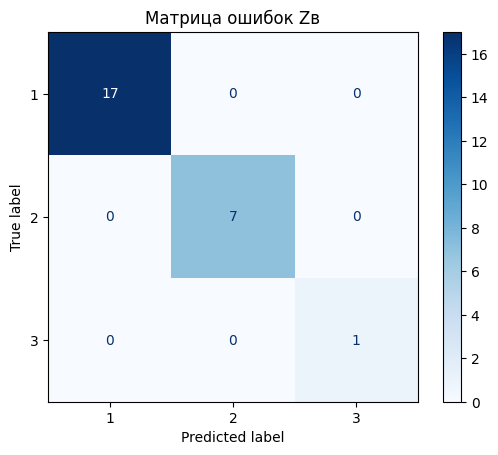

In [43]:
# Блок 9 - матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, cm.shape[0] + 1))
disp.plot(cmap='Blues')
plt.title("Матрица ошибок Zв")
plt.show()

In [44]:
# Блок 10 - сравнение предсказаний
test_comparison_model = pd.DataFrame({
    "Zв (истинное)": y_test.values,
    "Zв (предсказанное)": y_pred
})
print("\nСравнение предсказаний:")
print(test_comparison_model)


Сравнение предсказаний:
    Zв (истинное)  Zв (предсказанное)
0               1                   1
1               1                   1
2               1                   1
3               1                   1
4               3                   3
5               2                   2
6               2                   2
7               1                   1
8               1                   1
9               1                   1
10              1                   1
11              2                   2
12              1                   1
13              2                   2
14              1                   1
15              1                   1
16              1                   1
17              1                   1
18              1                   1
19              2                   2
20              1                   1
21              2                   2
22              1                   1
23              2                   2
24              1        